# PDFs from native MPAS mesh

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
%matplotlib inline
import xarray as xr
import numpy as np
import dask
import dask.array as da
import pandas as pd

import matplotlib.pyplot as plt
#increase font size
plt.rcParams.update({'font.size': 14})

In [2]:
lineColors = {
    'CTL' : 'gray',
    'minus4K' : 'tab:blue',
    'plus4K' : 'red',
    'HOMO_RAD' : 'purple',
}

### Spin up a dask cluster

In [3]:
# from ncar_jobqueue import NCARCluster
# cluster = PBSCluster()
# cluster.scale(4 * 9) # Ask for 4 x 9 workers
# cluster

from dask_jobqueue import PBSCluster
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk23-hpc',
    cores = 1,
    processes = 1,
    log_directory = '/glade/derecho/scratch/rberrios/dask/',
    local_directory = '/glade/derecho/scratch/rberrios/dask/',
    resource_spec = 'select=1:ncpus=1:mem=10GB',
    queue = 'casper',
    walltime = '12:00:00',
    interface = 'mgt'
)
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-wk23-hpc
#PBS -q casper
#PBS -A NMMM0004
#PBS -l select=1:ncpus=1:mem=10GB
#PBS -l walltime=12:00:00
#PBS -e /glade/derecho/scratch/rberrios/dask//
#PBS -o /glade/derecho/scratch/rberrios/dask//

/glade/u/apps/opt/conda/envs/npl-2024b/bin/python -m distributed.cli.dask_worker tcp://10.18.206.35:44961 --name dummy-name --nthreads 1 --memory-limit 101.51GiB --nanny --death-timeout 60 --local-directory /glade/derecho/scratch/rberrios/dask/ --interface mgt



Task exception was never retrieved
future: <Task finished name='Task-1147016' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/client.py:2278> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/client.py", line 2281, in wait
    st = self.futures[k]
         ~~~~~~~~~~~~^^^
KeyError: 'getattr-7c5e5c3e-a14c-4e6d-80cc-82253d9e62c5'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/client.py", line 2283, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1147017' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/client.

In [4]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rberrios/largeMem/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rberrios/largeMem/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.18.206.35:44961,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rberrios/largeMem/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# Scale the cluster to n workers (which will use n jobs here)
cluster.scale(36)

# Block progress until workers have spawned (typically only in demos and benchmarks!)
client.wait_for_workers(36)

In [6]:
# See the workers from the cluster object
cluster.workers

{'PBSCluster-19': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-1': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-33': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-3': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-17': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-22': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-13': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-18': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-27': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-5': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-21': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-20': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-24': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-9': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-35': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-16': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster

In [7]:
#read IC file to get the corresponding lat and lon
#output info
dx='TC_3km'
pth = '/glade/campaign/mmm/dpm/rberrios/glade_p/MPAS/aqua_sstmax10N/'
icfile = pth+dx+'/x5.tropical_3km_10N.init.nc'
ic = xr.open_dataset(icfile)
latCell = np.degrees(ic.latCell)
del(ic)

#find indexes within desired latitudinal range
ind_within_lat = np.where( (latCell >= -2.5) & (latCell <= 20.0) )[0]
latCell[ind_within_lat]

<xarray.DataArray 'latCell' (nCells: 12504537)> Size: 50MB
array([ 3.1051242,  3.083076 ,  3.0807054, ..., 18.667822 , 18.688522 ,
       18.709219 ], dtype=float32)
Dimensions without coordinates: nCells

In [22]:
def get_plot_pdf_given_dt(exps,dt,fac,units,bins):
    bins_ctr = 0.5*(bins[1:]+bins[:-1])
    
    fig,ax = plt.subplots()
    noRainPts = []
    xtmPts = []
    histAll = []
    for expName in exps:
        print(expName)
        pth='/glade/derecho/scratch/rberrios/te/tmp/%s/%s/'%(expName,dx)
        ds = xr.open_mfdataset(pth+'sub_history.2000-*.nc',
                              parallel = True,
                    concat_dim="time",
                    combine="nested")
        # add latitude to the dataset
        ds['latCell']=latCell
    
        ## now limit the data to tropics
        pr = ds.pr.isel(nCells=ind_within_lat)*fac #convert units
    
        ## check if we want to resample the data
        if (dt != '1H'):
            pr = pr.resample(time=dt).mean()
    
        # print(dask.compute(pr.max()))
        # get total number of points for normalization
        nTotal = (pr.shape[0]*pr.shape[1])
        print(nTotal)
    
        ## make sure we get number of non-rainy points
        pr = pr.where(pr>0.0)#.stack(z=('time','nCells')).dropna(dim='z')
        N = nTotal#len(pr)
        print(N)
    
        # get histogram
        hist, _ = da.histogram(pr,bins)
        del(pr,ds)
    
        # plot histogram
        hist = dask.compute(hist)
        
        # get number of non-rainy points
        noRain = (nTotal-np.sum(hist[0]))/nTotal
        noRainPts.append(noRain)
        
        # as in O'Gorman et al, normalize by the total number of points (inc. non-rainy)
        hist = hist[0]/nTotal
        histAll.append(hist)
        ax.plot(bins_ctr,hist,color=lineColors[expName])
        ax.set_yscale('log')
        ax.set_xscale('log')
    
        # plot non-rainy points
        ax.plot(bins_ctr[0],noRain,'.',color=lineColors[expName])
    
        # plot 90th percentile
        ax.axvline(x=xtm[expName],linestyle='--',color=lineColors[expName])
    plt.grid(True)
    ax.set_ylabel('fraction')
    ax.set_xlabel('rainfall rate (%s)'%units)

    # add figure label
    label=r'(f) N=%2.1f$\times10^9$'%np.round(N/1e9, 1) # Round to 1 decimal place

    ax.text(0.01, 0.982,label,
    horizontalalignment='left',
    verticalalignment='top',
    transform=ax.transAxes,
    fontsize='12', bbox=dict(facecolor='white', alpha=0.85)) 
    
    plt.savefig('./Figures/pdf_native_mesh_%s_2.5S-20N_ASD.pdf'%dt,dpi=300,bbox_inches='tight')
    print(noRainPts)

minus4K
2250816660
2250816660
CTL
2250816660
2250816660
plus4K
2250816660
2250816660
[0.0047576109553054404, 0.005641635423117936, 0.009211413069956573]


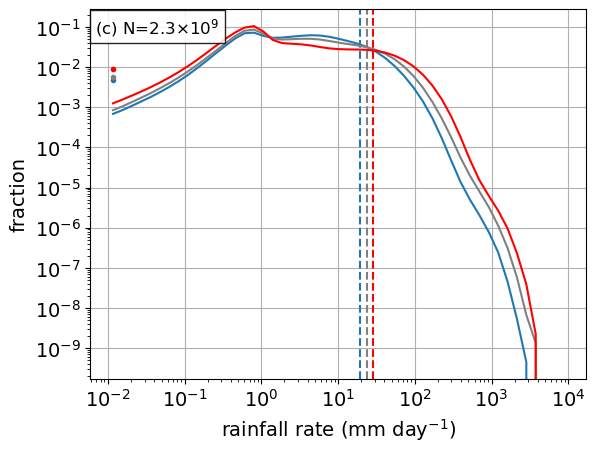

In [21]:
### call function to get and plot PDF
### -------------- DAILY -------------------- ###
dx='TC_3km'
dt='1D'
fac=24.0
units = 'mm day$^{-1}$'
bins = np.logspace(-2,4,50)

# extremes; calculated separately
xtm = {
    'minus4K':19.44, 
    'CTL': 23.51, 
    'plus4K':28.56,
}

get_plot_pdf_given_dt(['minus4K','CTL','plus4K'],dt,fac,units,bins)

minus4K
8965753029
8965753029
CTL
8965753029
8965753029
plus4K
8965753029
8965753029
[0.024337564652317616, 0.02984321786854341, 0.04404652199571535]


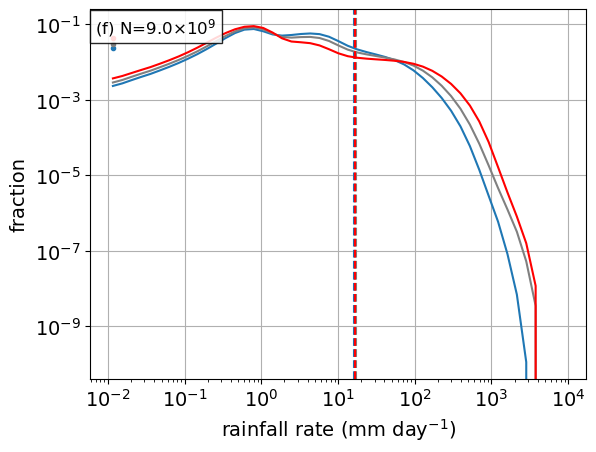

In [23]:
### -------------- SIX-HOURLY -------------------- ###
dx='TC_3km'
dt='6H'
# fac=1.0
# units = 'mm h$^{-1}$'
bins = np.logspace(-2,4,50)

# extremes; calculated separately
xtm = {
    'minus4K':16.18, 
    'CTL': 17.1, 
    'plus4K':16.56,
}

get_plot_pdf_given_dt(['minus4K','CTL','plus4K'],dt,fac,units,bins)

### Percentiles from the full native dataset (tropics only)

In [25]:
import pandas as pd

### Open files with xarray
dx='TC_3km'
dt='6H'
fac=24.0
# percentiles = [0.1,1.0,10.0,50.0,90.0,99.0,99.9]
percentiles = [i for i in np.arange(90.0,100.0,0.1)]

noRainPts = []
xtmPts = []

for expName in ['minus4K','CTL','plus4K']:
    print(expName)
    pth='/glade/derecho/scratch/rberrios/te/tmp/%s/%s/'%(expName,dx)
    ds = xr.open_mfdataset(pth+'sub_history.2000-*.nc',
                          parallel = True,
                concat_dim="time",
                combine="nested")
    # add latitude to the dataset
    ds['latCell']=latCell

    ## now limit the data to tropics
    pr = ds.pr.isel(nCells=ind_within_lat).chunk({"time": -1, "nCells": "auto"})
    
    ## check if we want to resample the data
    if (dt != '1H'):
        pr = pr.resample(time=dt).mean()

    ## scale
    pr = pr.where(pr>0)*fac

    ## convert to dask dataframe
    # prDF = pr.to_dask_dataframe()['pr']

    # Calculate percentiles
    print('getting perc...')
    xtm = np.nanpercentile(pr,percentiles)
    # print(xtm)

    # xtm = pr.quantile(percentiles)
    # xtm = dask.compute(xtm)
    xtmPts.append(xtm)

    data = {
        'percentiles':percentiles,
        'values':xtm,
    }
    df = pd.DataFrame(data)
    df.to_csv('./extremes_%s_%s_2.5S-20N.csv'%(dt,expName))
    
# print(xtmPts)

minus4K
getting perc...
CTL
getting perc...
plus4K
getting perc...


In [10]:
from tabulate import tabulate

headers = percentiles
print(tabulate(xtmPts, headers=headers, tablefmt="grid"))

+-------------+-----------+----------+---------+---------+----------+---------+
|         0.1 |       1.0 |     10.0 |    50.0 |    90.0 |     99.0 |    99.9 |
+=============+===========+==========+=========+=========+==========+=========+
| 0.0020752   | 0.0473404 | 0.372192 | 2.4532  | 19.4431 |  65.5106 | 136.318 |
+-------------+-----------+----------+---------+---------+----------+---------+
| 0.00167847  | 0.0369873 | 0.329147 | 1.85724 | 23.511  |  86.7104 | 181.466 |
+-------------+-----------+----------+---------+---------+----------+---------+
| 0.000762939 | 0.0211029 | 0.258865 | 1.09059 | 28.5586 | 120.079  | 245.734 |
+-------------+-----------+----------+---------+---------+----------+---------+


In [11]:
# calculate percent change
def perc_change(dT,a,b):
    return (100*((b-a)/a)/dT)

m4K = ['minus4K->CTL']
p4K = ['CTL->plus4K']
dT = 4 #fixed at 4K
for i in np.arange(0,len(percentiles)):
    change = perc_change(dT,xtmPts[0][i],xtmPts[1][i])
    m4K.append(change)
    change = perc_change(dT,xtmPts[1][i],xtmPts[2][i])
    p4K.append(change)

headers=['experiment']+percentiles

# print out
print(tabulate([m4K,p4K], headers=headers, tablefmt="grid"))

+--------------+-----------+-----------+----------+-----------+---------+---------+---------+
| experiment   |       0.1 |       1.0 |     10.0 |      50.0 |    90.0 |    99.0 |    99.9 |
+==============+===========+===========+==========+===========+=========+=========+=========+
| minus4K->CTL |  -4.77941 |  -5.46737 | -2.89132 |  -6.07331 | 5.23048 | 8.09023 | 8.27986 |
+--------------+-----------+-----------+----------+-----------+---------+---------+---------+
| CTL->plus4K  | -13.6364  | -10.7364  | -5.33819 | -10.3197  | 5.36727 | 9.62082 | 8.85396 |
+--------------+-----------+-----------+----------+-----------+---------+---------+---------+


### Check if extreme precip is associated w/ TCs

In [ ]:
def read_multiple_files_dask(pth,handle,varName,ind_within_lat,factor,resample_dt):

    ds = xr.open_mfdataset(pth+handle+'*.nc',
                          parallel = True,
                concat_dim="time",
                combine="nested")

    if ('mcs-candidates' in handle):
        # rename ncol as nCells
        ds = ds.rename({'ncol':'nCells'})
        
    ## now limit the data to tropics
    var = ds[varName].isel(nCells=ind_within_lat).chunk({"time": -1, "nCells": "auto"})*factor

    ## check if we want to resample the data
    if (dt != '1H'):
        var = var.resample(time=dt).mean()

    return var

In [ ]:
%%time
top_percentile = {
    'minus4K': 98.546,#111.703,
    'CTL': 134.96,#154.493,
    'plus4K': 188.69,#220.62}
}

### Open files with xarray
dx='TC_3km'
dt='6H'
fac=24.0

counts = {}

for expName in ['minus4K','CTL','plus4K']:
    xtm = top_percentile[expName]
    print(expName,xtm)
    pth='/glade/derecho/scratch/rberrios/te/tmp/%s/%s/'%(expName,dx)
    countsPerMonth = {}
    for month in np.arange(5,11):
        handle = 'sub_history.2000-%2.2i'%month
        print(handle)
        pr = read_multiple_files_dask(pth,handle,'pr',ind_within_lat,fac,dt)
        #convert to dask dataframe
        prDF = pr.to_dask_dataframe()['pr']
        #prDF = prDF[prDF>xtm]
        nTot = len(prDF[prDF>xtm].dropna())
        
        ## drop nans and count number of points
        #nTot = len(pr.where(pr>xtm).stack(z=('time','nCells')).dropna(dim='z'))
        print('all points exceeding threshold: %i'%nTot)
        
        ## now do the same but for the masked organized systems, including TCs
        handle='mcs-candidates.2000-%2.2i'%month
        sysID = read_multiple_files_dask(pth,handle,'binary_tag',ind_within_lat,1.0,dt)
        ## convert to dask dataframe
        sysDF = sysID.to_dask_dataframe()['binary_tag']
        ## drop nans and count number of points
        #nSys = len(pr.where( (pr>xtm) & (sysID>0.0)).stack(z=('time','nCells')).dropna(dim='z'))
        nSys = len(prDF[(prDF>xtm) & (sysDF>0)].dropna())
        print('all points inside an organized system: %i'%nSys)
        del(sysDF)
        
        ## repeat for organized systems EXCLUDING TCs
        handle='mcs-candidates-notcs.2000-%2.2i'%month
        orgID = read_multiple_files_dask(pth,handle,'binary_tag',ind_within_lat,1.0,dt)    
        ## convert to dask dataframe
        orgDF = orgID.to_dask_dataframe()['binary_tag']
        
        ## drop nans and count number of points
        #nOrg = len(pr.where( (pr>xtm) & (orgID>0.0)).stack(z=('time','nCells')).dropna(dim='z'))
        nOrg = len(prDF[(prDF>xtm)&(orgDF>0)])
        print('all points inside a non-TC organized system: %i'%nOrg)
        del(orgDF)
        
        ## number of TCs is the difference between nSys and nOrg
        nTCs = nSys-nOrg
        print('all points associated w/ TCs: %i'%nTCs)
        
        ## repeat for MCSs dataset EXCLUDING TCs and short-lived MCSs
        handle='mcs-stitched.2000-%2.2i'%month
        mcsID = read_multiple_files_dask(pth,handle,'MCS',ind_within_lat,1.0,dt)    
        ## convert to dask dataframe
        mcsDF = mcsID.to_dask_dataframe()['MCS']
        ## drop nans and count number of points
        ##nMCS = len(pr.where( (pr>xtm) & (mcsID>0.0)).stack(z=('time','nCells')).dropna(dim='z'))
        nMCS = len(prDF[(prDF>xtm)&(mcsDF>0)])
        print('all points associated w/ MCSs: %i'%nMCS)
        del(mcsDF)
    
        ## number of short-lived systems is the difference between all non-TC systems minus MCSs
        nSL = nOrg-nMCS
        print('all points associated w/ short-lived organized systems (non TC, non MCS): %i'%nSL)
    
        dataOut = {
            'nTot':nTot,
            'nMCS':nMCS,
            'nTCs':nTCs,
            'nSL':nSL
        }
        str = '%2.2i'%month
        countsPerMonth[str]=dataOut
        print(countsPerMonth)
        
    counts[expName]=countsPerMonth
    print(counts)
    
    # print(nSys/nTot,nMCS/nTot,nTCs/nTot,nSL/nTot)

In [ ]:
counts = {
    'minus4K' : {'05': {'nTot': 15675350, 'nMCS': 9626634, 'nTCs': 1718652, 'nSL': 556052}, '06': {'nTot': 14656386, 'nMCS': 9363417, 'nTCs': 1008258, 'nSL': 537358}, '07': {'nTot': 14626020, 'nMCS': 9308600, 'nTCs': 917680, 'nSL': 560051}, '08': {'nTot': 16150686, 'nMCS': 10762822, 'nTCs': 1091272, 'nSL': 618581}, '09': {'nTot': 15319594, 'nMCS': 8770892, 'nTCs': 2238117, 'nSL': 546188}, '10': {'nTot': 11983452, 'nMCS': 7140623, 'nTCs': 1079166, 'nSL': 445122}},
    'CTL':{'05': {'nTot': 14660711, 'nMCS': 10110174, 'nTCs': 1331471, 'nSL': 523863}, '06': {'nTot': 14294772, 'nMCS': 9559105, 'nTCs': 1610281, 'nSL': 512383}, '07': {'nTot': 14886355, 'nMCS': 10000807, 'nTCs': 1707161, 'nSL': 523605}, '08': {'nTot': 15319237, 'nMCS': 9836389, 'nTCs': 2377129, 'nSL': 491735}, '09': {'nTot': 15488829, 'nMCS': 10791560, 'nTCs': 1352365, 'nSL': 566741}, '10': {'nTot': 13514000, 'nMCS': 8597307, 'nTCs': 1987661, 'nSL': 453844}},
    'plus4K':{'05': {'nTot': 16205981, 'nMCS': 12848198, 'nTCs': 2120975, 'nSL': 315929}, '06': {'nTot': 15163108, 'nMCS': 11346585, 'nTCs': 2599056, 'nSL': 305143}, '07': {'nTot': 14702216, 'nMCS': 11943664, 'nTCs': 1130486, 'nSL': 362445}, '08': {'nTot': 14109920, 'nMCS': 11072326, 'nTCs': 1471758, 'nSL': 378310}, '09': {'nTot': 14704907, 'nMCS': 11425611, 'nTCs': 1883511, 'nSL': 325802}, '10': {'nTot': 12486838, 'nMCS': 9813748, 'nTCs': 1262827, 'nSL': 317396}}
}

for expName in ['minus4K','CTL','plus4K']:
    nTot=0
    nSys=0
    nTCs=0
    nMCS=0
    nSL=0
    for month in np.arange(6,11):
        nTot = nTot+counts[expName]['%2.2i'%month]['nTot']
        nMCS = nMCS+counts[expName]['%2.2i'%month]['nMCS']
        nTCs = nTCs+counts[expName]['%2.2i'%month]['nTCs']
        nSL  = nSL +counts[expName]['%2.2i'%month]['nSL']

    nSys = nMCS+nTCs+nSL
    print(nTot,nSys,nMCS,nTCs,nSL)
    print(nSys/nTot,nMCS/nTot,nTCs/nTot,nSL/nTot)

In [ ]:
# CTL
# 265457
# 240341
# 190535
# 49806
# 0.9053858063641192 0.7177621987741895 0.18762360758992983

### Percentiles from OLR to assist in MCS detection

In [ ]:
from tabulate import tabulate

dx='TC_3km'
dt='6H'
fac=1.0
varName='olrtoa'
percentiles = [1.0,10.0,25.0,50.0]

noRainPts = []
xtmPts = []

for expName in ['minus4K','CTL','plus4K']:
    print(expName)
    pth='/glade/derecho/scratch/rberrios/te/tmp/%s/%s/'%(expName,dx)
    ds = xr.open_mfdataset(pth+'sub_history.2000-*.nc',
                          parallel = True,
                concat_dim="time",
                combine="nested")
    # add latitude to the dataset
    ds['latCell']=latCell

    ## now limit the data to tropics
    var = ds[varName].isel(nCells=ind_within_lat).chunk({"time": -1, "nCells": "auto"})
    
    ## check if we want to resample the data
    if (dt != '1H'):
        var = var.resample(time=dt).mean()

    ## scale
    if (varName == 'pr'):
        var = var.where(var>0)*fac
    
    # Calculate percentiles
    print('getting perc...')
    xtm = np.nanpercentile(var,percentiles)
    print(xtm)

    # xtm = pr.quantile(0.99)
    # xtm = dask.compute(xtm)
    xtmPts.append(xtm)

headers = percentiles
print(tabulate(xtmPts, headers=headers, tablefmt="grid"))

m4K = ['minus4K->CTL']
p4K = ['CTL->plus4K']
dT = 4 #fixed at 4K
for i in np.arange(0,len(percentiles)):
    change = perc_change(dT,xtmPts[0][i],xtmPts[1][i])
    m4K.append(change)
    change = perc_change(dT,xtmPts[1][i],xtmPts[2][i])
    p4K.append(change)

headers=['experiment']+percentiles

# print out
print(tabulate([m4K,p4K], headers=headers, tablefmt="grid"))

In [ ]:
client.close()

In [ ]:
# ---- median OLR from the last 7 days:
# minus4K: 245
# CTL: 250.5
# plus4K: 252.5

# ---- 10th percentile (eq. to 90th bc OLR decreases with more active conv.) from the last 7 days:
# minus4K: 139.5
# CTL: 141.0 #---so 140 is on point for convective cores!
# plus4K: 145.5